<a href="https://colab.research.google.com/github/mahbodnr/Mask-Detection/blob/main/Project_Brain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TODO:

- <s>neuron id </s>
- <s>define a global timestep</s>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from itertools import count
import networkx as nx
from tqdm.notebook import tqdm
import time
import PIL
import cv2
import warnings

# Neuron Types

In [ ]:
class NeuronType(object):
    pass

##LIF<br>
$u = u_r + \int 1/C * exp(t-t'/\tau) * I(t')dt'$

In [ ]:
class LIF(NeuronType):
    def __init__(self,  Rm = 1,Cm = 0.1):
        self.Rm = Rm #ohm
        self.Cm = Cm #uF
        self.tau_m = Rm*Cm
        self.mode='lif'
    def __call__(self, current, timestep, last_spike_timepoint,):
        potential = 0
        for timepoint in range(last_spike_timepoint, timestep + 1):
            potential += 1/self.Cm * (np.exp(-(timestep - timepoint)/self.tau_m)) * current[timepoint]
        return potential

## Izhikevich model
https://www.izhikevich.org/publications/spikes.htm
http://www.columbia.edu/cu/appliedneuroshp/Spring2018/Spring18SHPAppliedNeuroLec5.pdf
https://stackoverflow.com/questions/53745156/izhikevich-neuron-model-equations


In [ ]:
## Hafez
class Izhikevich(NeuronType):
    def __init__(self, c =-65, d=2, c1=0.04, c2=5, c3=140, c4=1, c5=1, a=0.02, b=0.2, v_rest=30):
        self.c = c  #mv
        self.d = d  #mv
        self.c1 = c1    #mv/ms
        self.c2 = c2    #1/ms
        self.c3 = c3    #mv/ms
        self.c4 = c4    #1/ms
        self.c5 = c5    #mv.ohm/(ms^2.A)
        self.a = a  # dimless
        self.b = b  # dimless
        self.mode = 'izh'
        self.u_rest = u_rest
    def __call__(self, current, timestep, last_spike_timepoint, v_init, recovery):
        v = v_init
        for timepoint in range(last_spike_timepoint, timestep + 1):
            v += self.c1*(v**2) + self.c2*v+self.c3-self.c4*recovery+self.c5*current[timepoint]
            recovery += self.a*(self.b*v-recovery)
        return v, recovery

# Neuron

In [3]:
class Neuron(object):
    _ids = count(0)
    def __init__(self, total_timepoints,  model = LIF(),
                 neurotransmitter = 'inhibitory', tau_ref = 4, u_rest = -68,
                 u_tresh = +30, save_potential_history = False,):
        """
        Define a new Neuron object
        Args:

        """
        self.id = next(self._ids)
        self.total_timepoints = total_timepoints
        self.model = model
        self.neurotransmitter = neurotransmitter
        self.tau_ref = tau_ref #ms # refractory period
        self.u_rest = u_rest #mv
        self.u_tresh = u_tresh #mv
        self.u = self.u_rest
        self.save_potential = save_potential_history
        self.open = True
        self.current_history = np.zeros(total_timepoints)
        self.spike_train =  np.zeros(total_timepoints, dtype = np.bool)
        self.last_spike_timepoint = 0
        if self.save_potential:
            self.potential = np.zeros(total_timepoints)
        self.connected_to_external_source = False
        self.current = 0
        self.timestep = 0
        ## Hafez
        if self.model.mode == 'izh':
            self.recovery = self.model.u_rest*self.model.b
        
    def step(self):
        assert self.timestep < self.total_timepoints, "Simulation interval has been finished!"
        # Check refactory interval
        if not self.open:
            if self.refactory_time < self.tau_ref - 1:
                self.refactory_time += 1
            else:
                self.open = True
        else:
            # Add current current to current history :)
            self.current_history[self.timestep] = self.current
            # Update
            self.u = self.u_rest
            ## Hafez
            if self.model.mode == 'lif':
                self.u += self.model(self.current_history, self.timestep, self.last_spike_timepoint)
            if self.model.mode == 'izh':
                self.u, self.recovery = self.model(self.current_history, self.timestep, self.last_spike_timepoint, self.u, self.recovery)

            # Save potential history
            if self.save_potential:
                self.potential[self.timestep] = self.u
            # Spike
            if self.u > self.u_tresh:
                self.last_spike_timepoint = self.timestep + self.tau_ref
                self.spike_train[self.timestep] = True
                self.open = False
                self.refactory_time = 0 
                if self.model.mode == 'izh':
                    self.recovery += self.model.d
        # Empty neuron's current
        self.current = 0

    @property
    def spike(self):
        return self.spike_train[self.timestep - 1]

    def display_spikes(self):
        spike_train = self.spike_train.astype(str)
        spike_train[spike_train=='True'] = '|'
        spike_train[spike_train=='False'] =  " "
        return ''.join(np.array2string(spike_train).split("'")[1:-1:2])

# Neuron Group

In [16]:
class NeuronGroup(object):
    _ids = count(0)
    order = 1
    def __init__(self, population, total_timepoints, connection_chance=1/10,
                    excitatory_rate=2 /10, base_current = 50, save_gif = False):
        """
        """
        self.id = next(self._ids)
        self.total_timepoints = total_timepoints
        self.population = population
        self.base_current = base_current
        self.save_gif = save_gif
        if save_gif:
            warnings.warn('WARNING: "save_gif" is set to True, it can considerably slow down the simulation process. To see the result use "save_gif_to" function after training')
            self.images = []
            # Disable matplotlib inline mode:
            %matplotlib notebook
        self.neurons = {
            Neuron(total_timepoints, 
                   neurotransmitter = 'inhibitory' if random.random() > excitatory_rate else 'excitatory')
            for _ in range(self.population)}
                

        self.network = nx.DiGraph()
        self.network.add_nodes_from(self.neurons)
        for PreSN in self.network.nodes:
            for PostSN in self.network.nodes:
                if PreSN != PostSN:
                    if random.random() < connection_chance:
                        self.network.add_edge(PreSN, PostSN, weight = np.random.rand(1))
        self.pos = None
        self.timestep = 0

    def step(self, learning=False, learning_rule='flat_stdp', learning_params=None):
        self.active_neurons = set()
        for neuron in self.neurons:
            neuron.timestep = self.timestep
            neuron.step()
            if neuron.spike:
                self.active_neurons.add(neuron)

        for neuron in self.neurons:
            if neuron.spike:
                for preSN, postSN, weight in self.network.out_edges(neuron, data = 'weight'):
                    if postSN.open:
                        postSN.current += self.base_current * weight
                        ## Hafez
                        if learning:
                            if learning_rule == 'flat_stdp':
                                if preSN.last_spike_timepoint <= postSN.last_spike_timepoint:
                                    self.network[preSN._ids][postSN._ids]["weight"] +=\
                                     learning_params[0]*self.network[preSN._ids][postSN._ids]*(1-self.network[preSN._ids][postSN._ids])
                                else:
                                    self.network[preSN._ids][postSN._ids]["weight"] +=\
                                     -learning_params[0]*self.network[preSN._ids][postSN._ids]*(1-self.network[preSN._ids][postSN._ids])  
    
        if self.save_gif:
            fig, _ = self.draw_graph()
            self.images.append(self._fig_to_PIL_image(fig))
    
    def draw_graph(self, display_ids = False):
        # Set graph position 
        if not self.pos:
            input_neurons = set()
            for neuron in self.neurons:
                if neuron.connected_to_external_source:
                    input_neurons.add(neuron)
            self.pos = {}
            for y, neuron in enumerate(input_neurons):
                self.pos[neuron] = (0, (y+1) / (len(input_neurons)+1))
            last_layer = input_neurons
            for x in range(1, len(self.network.nodes())):
                counted_neurons = set(self.pos.keys()) 
                next_layer = set()
                for neuron in last_layer:
                    next_layer.update(self.network.successors(neuron))
                new_neurons = next_layer - counted_neurons
                if new_neurons == set():
                    break
                else:
                    for y, neuron in enumerate(new_neurons):
                        self.pos[neuron] = (x, (y+1)/(len(new_neurons)+1))

                last_layer = next_layer
        fig, ax = plt.subplots(figsize=(10,8))
        nx.draw_networkx_edges(self.network, pos=self.pos, ax=ax, edge_color="gray")
        inactive_neurons = nx.draw_networkx_nodes(self.network, pos=self.pos, ax=ax,
            nodelist=set(self.network.nodes()) - (group.active_neurons),
            node_color="gray",)
        inactive_neurons.set_edgecolor("black")
        active_neurons = nx.draw_networkx_nodes(self.network, pos=self.pos, ax = ax,
                                             nodelist=group.active_neurons,
                                             node_color='blue',)
        active_neurons.set_edgecolor("black")
        if display_ids:
            nx.draw_networkx_labels(group.network, pos = self.pos, ax = ax,
                labels = {neuron: neuron.id for neuron in group.network.nodes})
        return fig, ax
            
    def _fig_to_PIL_image(self, fig):
        fig.savefig("test.jpg")
        img = cv2.imread("test.jpg")
        return PIL.Image.fromarray(img)

    def save_gif_to(self, path, **kwargs):
        assert self.save_gif, "No gif has been saved during the simulation. To use this function you must set 'save_gif' to True"
        frame0 = self.images.pop(0)
        frame0.save(path, save_all=True, append_images=self.images, **kwargs)

    def display_spikes(self):
        spike_train = ' id\n' + '=' * 5 + '╔' + '═' * self.total_timepoints + '╗\n'
        for neuron in self.neurons:
            spike_train += str(neuron.id) + ' ' * (5 - len(str(neuron.id))) \
            + '║' + neuron.display_spikes() + '║\n'  
        spike_train +=' ' * 5 + '╚' + '═' * self.total_timepoints + '╝'
        print(spike_train)

# Stimulus

In [17]:
class stimulus(object):
    _ids = count(0)
    order = 0
    def __init__(self, output, dt):
        """
        Parameters
        ----------
        output: function
        A function that determines the output of the stimulus
        in a specific timestep.
        examples:
        output = lambda t: np.sin(2 * t)
        output = lambda t: 2

        Returns
        -------
        Returns the value of output if no connection is set.
        otherwise, sends the value to the connection (returns None).
        """
        self.output = output
        self.connection = None
        self.id = next(self._ids)
        self.timestep = 0
        self.dt = dt

    def connect(self, connection):
        connection.connected_to_external_source = True
        self.connection = connection

    def step(self):
        if self.connection == None:
            warnings.warn(f"WARNING: Stimulus (id: {self.id}) has not connected to any object!")
            return self.output(self.timestep * self.dt)
        self.connection.current += self.output(self.timestep * self.dt)

    @property
    def value(self):
        return self.output(self.timestep * self.dt)


#Simulation

In [26]:
class simulation(object):
    def __init__(self, total_time, dt):
        """
        """
        self.total_timepoints = int(total_time/ dt)
        self.timestep = 0
        self.objects = set()
        self.dt = dt

    def NeuronGroup(self, population, **kwargs):
        G = NeuronGroup(population, self.total_timepoints,**kwargs)
        self.objects.add(G)
        return G

    def stimulus(self, output):
        stim = stimulus(output, self.dt)
        self.objects.add(stim)
        return stim

    def step(self,learning=False, learning_rule='flat_stdp', learning_params=None):
        self.timestep += 1
        for obj in sorted(self.objects, key= lambda obj: obj.order):
            obj.step()
            obj.timestep = self.timestep

    def run(self):
        start_time = time.time()
        for _ in tqdm(range(self.total_timepoints)):
            self.step()
        run_time = time.time() - start_time
        print(f"Simulation finished in {round(run_time,2)}s")

    @property
    def time(self):
        return self.timestep * self.dt

# Run

In [19]:
sim = simulation(total_time= 0.05, dt = 0.001)
group = sim.NeuronGroup(30, connection_chance= 1/2, save_gif = True)
stim1 = sim.stimulus(lambda t : 50)
stim2 = sim.stimulus(lambda t : 50 *np.sin(5*t))
stim3 = sim.stimulus(lambda t : 50 * np.log(t + 1))
neurons_list = list(group.neurons)
input_neuron1 =  neurons_list[0]
input_neuron2 =  neurons_list[1]
input_neuron3 =  neurons_list[2]
stim1.connect(input_neuron1)
stim2.connect(input_neuron2)
stim3.connect(input_neuron3)

sim.run()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: WARNING: "save_gif" is set to True, it can considerably slow down the simulation process. To see the result use "save_gif_to" function after training
  if sys.path[0] == '':


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Simulation finished in 156.31s


In [20]:
group.display_spikes()

 id
=====╔════════════════════════════════════════════════════════════════════════════════════════════════════╗
91   ║|    |    |    |    |    |    |    |    |    |    |    |    |    |    |    |    |    |    |    |    ║
98   ║  |    |    |    |    |    |    |    |    |    |    |    |    |    |    |    |    |    |    |    |  ║
94   ║    |    |    |    |    |    |    |    |    |    |    |    |    |    |    |    |    |    |    |    |║
117  ║  |    |    |    |    |    |    |    |    |    |    |    |    |    |    |    |    |    |    |    |  ║
90   ║    |    |    |    |    |    |    |    |    |    |    |    |    |    |    |    |    |    |    |    |║
99   ║  |    |    |    |    |    |    |    |    |    |    |    |    |    |    |    |    |    |    |    |  ║
113  ║  |    |    |    |    |    |    |    |    |    |    |    |    |    |    |    |    |    |    |    |  ║
95   ║    |    |    |    |    |    |    |    |    |    |    |    |    |    |    |    |    |    |    |    |║
106  ║    |    |    |   

(<Figure size 720x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5f29aba410>)

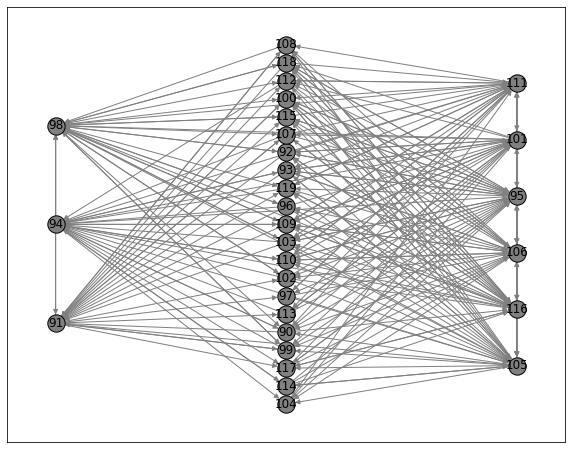

In [23]:
%matplotlib inline
group.draw_graph(display_ids= True)

In [24]:
group.save_gif_to('test.gif',  fps=2, loop=0)